In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import euclidean

datapoints = [
    ["A", 5, 4],
    ["B", 4, 7],
    ["C", 6, 8],
    ["D", 8, 2],
    ["E", 12, 7],
    ["F", 11, 6],
]
coords = ["x", "y"]
columns = ["point"] + coords
points = pd.DataFrame(datapoints, columns=columns)
points[coords] = points[coords].astype(np.float32)
points
get_coords = lambda x: points.loc[points.point == x, coords].values.flatten()


In [2]:
get_clusters = lambda: points.point.values.tolist()
clusters = get_clusters()


In [3]:
def _calc_all_euclids(clust1, clust2):
    if not isinstance(clust1, list):
        clust1 = [clust1]
    if not isinstance(clust2, list):
        clust2 = [clust2]
    distances = list()
    for p1_name in clust1:
        for p2_name in clust2:
            p1 = get_coords(p1_name)
            p2 = get_coords(p2_name)
            distances.append(euclidean(p1, p2))
    return distances


def _min_lin(clust1, clust2):
    distances = _calc_all_euclids(clust1.split(","), clust2.split(","))
    return min(distances)


def _max_lin(clust1, clust2):
    distances = _calc_all_euclids(clust1.split(","), clust2.split(","))
    return max(distances)


In [4]:
def get_proximity_matrix(clusters: pd.DataFrame, lin="max") -> pd.DataFrame:
    dist = np.zeros((len(clusters), len(clusters)))
    for x_idx, clust1 in enumerate(clusters):
        for y_idx, clust2 in enumerate(clusters):
            if clust1 == clust2:
                val = 0
            else:
                if "," in clust1 or "," in clust2:
                    if lin == "max":
                        val = _max_lin(clust1, clust2)
                    else:
                        val = _min_lin(clust1, clust2)
                else:
                    p1 = get_coords(clust1)
                    p2 = get_coords(clust2)
                    val = euclidean(p1, p2)

            dist[y_idx][x_idx] = val
    dist = pd.DataFrame(dist, columns=clusters, index=clusters)
    print(dist)
    return dist + np.diag([np.inf] * dist.shape[0])


In [5]:
def get_points_to_merge(dist: pd.DataFrame) -> list:
    distance = dist.min().min()
    p1, p2 = np.where(dist == distance)[0]
    p1, p2 = dist.index[[p1, p2]].values.tolist()
    print(p1, p2, distance)
    return [p1, p2, distance]


In [99]:
def merge_points(clusters: list, p1, p2, clust_mapping):
    clusters.remove(p1)
    clusters.remove(p2)
    new_clust = f"{p1},{p2}"
    clusters.append(new_clust)
    clust_mapping[new_clust] = len(clust_mapping.keys())
    print(clusters)


In [100]:
def append_children(children: list, p1, p2, clust_mapping):
    children.append(np.array([clust_mapping[p1], clust_mapping[p2]]))


def append_distances(distances: list, dist):
    distances.append(dist)


In [114]:
clusters = get_clusters()
clust_mapping = {point: idx for idx, point in enumerate(points.point.values)}
children = list()
distances = list()


In [119]:
dist = get_proximity_matrix(clusters, lin="max")
p1, p2, distance = get_points_to_merge(dist)
merge_points(clusters, p1, p2, clust_mapping)
append_children(children, p1, p2, clust_mapping)
append_distances(distances, distance)


         E,F  B,C,A,D
E,F      0.0      8.0
B,C,A,D  8.0      0.0
E,F B,C,A,D 8.0
['E,F,B,C,A,D']


In [120]:
children = np.array(children)
distances = np.array(distances)

In [121]:
# adjusted code from here: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(children, distances, data_labels, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    n_samples = len(data_labels)
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [children, distances, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

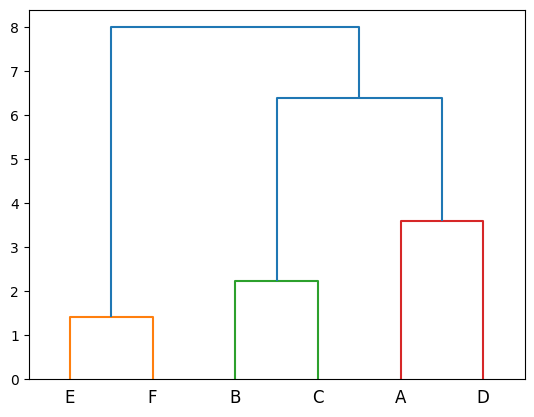

In [122]:
plot_dendrogram(children, distances, points.point.values.tolist(), labels=points.point.values.tolist())